## Introduction - Purpose: 

The schools run various remedial program for heping out students who have done poorly in assessments. 

The logic behind selection for students for such programs often varie from school to school is very dependant on the teacher. 

Clustering the students on the basis of their past assessment results will bring out patterns that will help us classify them into natural groups consisting of students of similar level of competency

Currently, we have assessment data for various FA, SA tests. The idea is to look at two factors for clustering : 
- Their overall 'average' performance across the assessments 

- The variability of their scores across the assessments 

The idea is to be able to treat student who have been consistently doing poorly/well different from the student who are more irregular with both high and low scores.  

## Toggling the raw codes: 

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

## Importing Libraries and connecting to SQL:

In [6]:
import pyodbc 
import psycopg2
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.stats import pearsonr

In [3]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [2]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
def open_connection(dbname,user,pwd,host_name,port ):
    conn = psycopg2.connect(database = dbname, user = user, password = pwd, host = host_name, port = port)
    print ("Connected successfully")
    return conn

In [11]:
def run_sql_code(sql_stmnt,conn) : 
    cursor = conn.cursor()
    cursor.execute( sql_stmnt )
    
    if cursor.pgresult_ptr is not None:
        sql_table = cursor.fetchall()
        column_names = [desc[0] for desc in cursor.description]
        sql_table_df =  pd.DataFrame(sql_table,columns = (column_names))
    else:
        sql_table_df =  "No table rows selected"

    return(sql_table_df)

### Connecting to  SQL server 
Enter password to connect to the Samarth Staging server : 

In [9]:
dbname ="postgres"
user = "postgres"
host_name = "143.110.183.73"
port = "15432"
pwd= getpass.getpass()

········


In [12]:
conn = open_connection(dbname,user,pwd,host_name,port )

Connected successfully


## Clustering example:

### Subsetting for Shimla

As I cannot pull the entirey of the data, I am currently using only data from the Shimla district.  A sample can be seen below: 

In [29]:
sql_stmnt = '''
CREATE TEMP table test_view_submissions_data_Shimla AS
select distinct assessment_percent,
    assessment_grade,
    CASE WHEN assessment_percent in  (0,-1) THEN  assessment_grade
     WHEN assessment_percent is null THEN assessment_grade
     WHEN assessment_percent BETWEEN 80 AND 100 THEN  'A'
     WHEN assessment_percent BETWEEN 65 AND 80 THEN  'B'
     WHEN assessment_percent BETWEEN 50 AND 65 THEN  'C'
     WHEN assessment_percent BETWEEN 35 AND 50 THEN  'D'
     WHEN assessment_percent BETWEEN 0 AND 35 THEN 'E' 
    END AS assessment_grade_all,
    CASE WHEN (assessment_percent not in (0,-1) and assessment_percent is not NULL) THEN  assessment_percent
     WHEN assessment_grade = 'A' THEN 87.5
     WHEN assessment_grade = 'B' THEN 72
     WHEN assessment_grade = 'C' THEN 57
     WHEN assessment_grade = 'D' THEN 42
     WHEN assessment_grade = 'E' THEN 24
     WHEN assessment_grade = 'Z' THEN NULL
    END AS assessment_percent_all,

    base.grade_number as subm_grade_number,
    student.grade_number as stud_grade_number,
    --subject.grade_number as Subject_grade_number,
    --subject_id,
    subject.name as Subject_desc,
    assessment_id,
    student_id,
    student.section as section,
    category,
    is_cwsn,
    admission_number,
    previous_acad_year,
    grade_year_mapping,
    deadline.date as submission_date, 
    deadline.acad_year as submission_academic_year ,
    CASE WHEN  assessment_type."desc" IS NULL THEN assessment."type" ELSE assessment_type."desc" 
    END AS assessment_type ,
    location.district as district,
    location.block as block, 
    location.cluster as cluster
     from student_submission base
    left join student on base.student_id  = student.id
        left join school on student.school_id = school.id
        left join assessment on base.assessment_id =  assessment.id   
        left join assessment_type on  assessment.type_v2_id  = assessment_type.id
        left join deadline on assessment.deadline_id =  deadline.id
        left join subject on base.subject_id =  subject.id 
        left join location  on school.location_id = location.id
        where student.is_enabled = 't'
            and school.is_active =  't'
            and school.udise > 1111111111 
            and location.district = 'SHIMLA' '''

df = run_sql_code(sql_stmnt,conn)

In [18]:
sql_stmnt = '''
Select *,RANK() OVER(PARTITION BY assessment_id,Subject_desc,subm_grade_number 
        ORDER BY assessment_percent_all DESC) as grade_number,
        COUNT(*) OVER  (PARTITION BY  assessment_id,Subject_desc,subm_grade_number ) as frequency,

100-(RANK() OVER(PARTITION BY assessment_id,Subject_desc,subm_grade_number 
        ORDER BY assessment_percent_all DESC) *100.000) / 
        COUNT(*) OVER  (PARTITION BY  assessment_id,Subject_desc,subm_grade_number ) as percentile_Score_Stud, 
        CASE WHEN assessment_grade_all in ('E') THEN 1 ELSE 0 END AS pass_fail
        from (
select base.* from test_view_submissions_data_Shimla base 
inner join 
(select * from
(select student_id,assessment_id,Subject_desc,subm_grade_number, count(distinct assessment_percent_all) as count_assessment 
from test_view_submissions_data_Shimla
where assessment_percent_all IS NOT NULL
group by  student_id,assessment_id,Subject_desc,subm_grade_number ) a
where count_assessment = 1) a 
on base.student_id =  a.student_id
and base.assessment_id  =  a.assessment_id
and base.Subject_desc = a.Subject_desc
and base.subm_grade_number  = a.subm_grade_number) a
where assessment_percent_all is not null
             '''

df = run_sql_code(sql_stmnt,conn)

In [19]:
#base_df = df
#base_df.to_csv('D:/Samagra/Samarth LR/main_df.csv',index=False)
base_df =  pd.read_csv('D:/Samagra/Samarth LR/main_df.csv')

In [30]:
### Pulling attandance data 

sql_stmnt = '''select student_id, count(*) as days, sum(CASE WHEN is_present = 't' THEN 1 ELSE 0 END) as present_days from attendance where 
student_id in (
select distinct  base.student_id from test_view_submissions_data_Shimla base 
inner join 
(select * from
(select student_id,assessment_id,Subject_desc,subm_grade_number, count(distinct assessment_percent_all) as count_assessment 
from test_view_submissions_data_Shimla
where assessment_percent_all IS NOT NULL
group by  student_id,assessment_id,Subject_desc,subm_grade_number ) a
where count_assessment = 1) a 
on base.student_id =  a.student_id
and base.assessment_id  =  a.assessment_id
and base.Subject_desc = a.Subject_desc
and base.subm_grade_number  = a.subm_grade_number) 
group by student_id '''
df = run_sql_code(sql_stmnt,conn)

In [32]:
attendance_df = df.to_csv('D:/Samagra/Samarth LR/attendance_df.csv',index=False)

In [33]:
base_df.loc[0:3,:]

,assessment_percent,assessment_grade,assessment_grade_all,assessment_percent_all,subm_grade_number,stud_grade_number,subject_desc,assessment_id,student_id,section,...,submission_date,submission_academic_year,assessment_type,district,block,cluster,grade_number,frequency,percentile_score_stud,pass_fail
0,-1.0,A,A,87.5,1,3,English,19,173181,A,...,2020-07-31 23:59:00+00:00,2019-2020,SA2,SHIMLA,RAMPUR,GPS NARAIN,1,1383,99.92769342010122921186,0
1,-1.0,A,A,87.5,1,3,English,19,308711,A,...,2020-07-31 23:59:00+00:00,2019-2020,SA2,SHIMLA,MASHOBRA,GPS KOTI,1,1383,99.92769342010122921186,0
2,-1.0,A,A,87.5,1,3,English,19,213543,A,...,2020-07-31 23:59:00+00:00,2019-2020,SA2,SHIMLA,DEHA,GPS BANDLI,1,1383,99.92769342010122921186,0
3,-1.0,A,A,87.5,1,3,English,19,263816,A,...,2020-07-31 23:59:00+00:00,2019-2020,SA2,SHIMLA,RAMPUR,GPS BAHALI,1,1383,99.92769342010122921186,0


In [20]:
base_df_marks =  base_df.loc[~base_df['assessment_percent'].isin([-1.0,0]),:]
base_df_marks_9_10 =  base_df_marks.loc[base_df['subm_grade_number'].isin([9,10]),:]

In [21]:
base_df_grades =  base_df.loc[base_df['assessment_percent'].isin([-1.0,0]),:]

In [22]:
base_df_grades= base_df_grades.loc[base_df_grades['assessment_type'].isin(['FA1','FA2','SA1','SA2']),:]

In [23]:
base_df_grades['grade_assestype'] = base_df_grades['subm_grade_number'].astype('str') + base_df_grades['assessment_type']

In [26]:
base_df_marks_9_10['grade_assestype'] = base_df_marks_9_10['subm_grade_number'].astype('str') + base_df_marks_9_10['assessment_type']

We have filtered for students of 9th and 10th grade. Looking at the distribution of scores for each subject :

Text(0.5, 1.0, 'Subject wise scores boxplot')

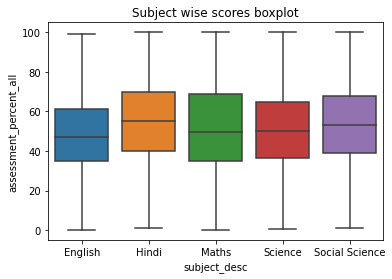

In [39]:
viz_df = base_df_marks_9_10
sns.boxplot(x='subject_desc' , y="assessment_percent_all",data=viz_df).set_title('Subject wise scores boxplot')

We see that Hindi registers the highest average score and Math  the biggest spread.  
On the other hand, English shows the lowest average scores.

In [40]:
years_students = base_df_marks_9_10.groupby(['student_id']).agg({'subm_grade_number':'nunique', 'grade_assestype':'nunique'}).reset_index()
#years_students.groupby(['subm_grade_number','grade_assestype']).agg({'student_id':'nunique'}).reset_index()
students_2exams_students =  years_students.loc[years_students['grade_assestype']==2,'student_id']

In [41]:
students_2exams_data = base_df_marks_9_10.loc[ base_df_marks_9_10['student_id'].isin(students_2exams_students.values),:]

### Understanding the assessment percentage and percentile metrics   : 

At a student assessment level we have measured their performance in two ways : 
    
- Assessment percentage :  This is the assessment score expressed in terms of percentage to have consistency across various assessments

- Assessment percentile : This is the assessment score expressed in terms of percentile comparing the score to all the other students of that district for that particular assessment
        

#### Example of difference in average test performance across assessments:

#####  Looking at the assessment percentage differences across tests: 

It must be pointed out that the assessment percentage might not necessarily be a good indicator of a students performance across tests relative to other students. 

For example if we look at the difference between the board exam and the pre-board exam results for students, we can see clearly see that there is an average increase in the scores of each student. For Maths/Science there is an average increase of the score by more than 20, while in other subjects it's around 10


In [42]:
students_2exams_data1 = students_2exams_data.loc[students_2exams_data['frequency'] > 20,:]

In [43]:
Percentile_diff_table = students_2exams_data1.pivot_table(index=['student_id','subject_desc'], columns='assessment_type', values='percentile_score_stud').reset_index()
Percentile_diff_table['Percentile_difference'] =  Percentile_diff_table['T2-9-12'] -  Percentile_diff_table['PB-10&12']

In [44]:
Percentage_diff_table = students_2exams_data1.pivot_table(index=['student_id','subject_desc'], columns='assessment_type', values='assessment_percent_all').reset_index()
Percentage_diff_table['Percentage_difference'] =  Percentage_diff_table['T2-9-12'] -  Percentage_diff_table['PB-10&12']

Text(0.5, 1.0, 'Percentage marks difference pre-boards and boards')

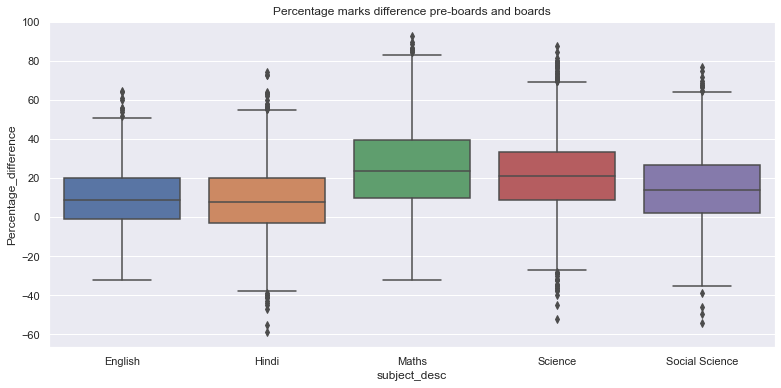

In [245]:
sns.set(rc={'figure.figsize':(13,6)})
sns.boxplot(x='subject_desc' , y="Percentage_difference",data=Percentage_diff_table).set_title('Percentage marks difference pre-boards and boards')

##### Looking at the difference in percentile scores:

When we look at the difference in the percentile scores, we see however that in general there is an average of 0 difference in the percentile scores between the two exams

Text(0.5, 1.0, 'Percentile marks difference pre-boards and boards')

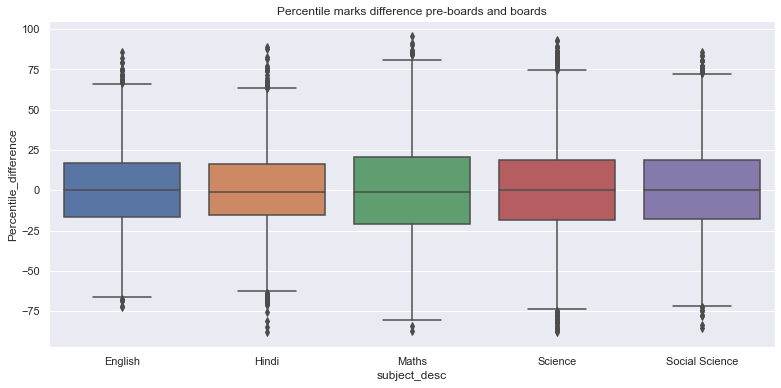

In [246]:
sns.set(rc={'figure.figsize':(13,6)})
sns.boxplot(x='subject_desc' , y="Percentile_difference",data=Percentile_diff_table).set_title('Percentile marks difference pre-boards and boards')

This means that an average student could get around 40 in the pre-boards in Math and around 60 in the boards. His percentile score will remain the same at around 50

Also, we can see here that Math has the biggest spread i.e. shows the most changes in percentile scores. This is further proof of it being the subject where one can see maximum change in performance scores with some kind of intervention

In [31]:
##Percentile_diff_table['Percentile_difference'].hist()
#plt.show()

In [45]:
students_2exams_data_stud_subj_lvl = students_2exams_data1.groupby(['student_id','subject_desc']).agg({'assessment_percent_all':'mean','percentile_score_stud':'std'}).reset_index()
students_2exams_data_stud_subj_lvl = students_2exams_data_stud_subj_lvl.loc[~students_2exams_data_stud_subj_lvl['percentile_score_stud'].isnull(),:]

### Create clusters

#### Elbow chart

The elbow chart is used to get an idea on what are the number of clusters to be created such that the patterns are separate from each other. The number at which the elbow is being formed is the point at which sharp clusters are being defined and should be used

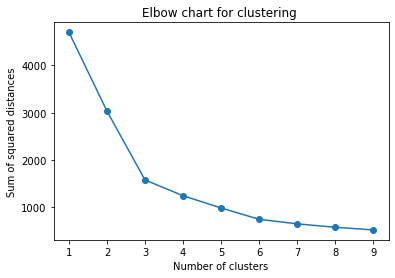

In [37]:
Maths_students_2exams_data_stud_subj_lvl = students_2exams_data_stud_subj_lvl.loc[students_2exams_data_stud_subj_lvl['subject_desc']== 'Maths',:]
clustering_data = Maths_students_2exams_data_stud_subj_lvl[['assessment_percent_all','percentile_score_stud']].copy()
scaler = StandardScaler().fit(clustering_data)
standardized_clustering_data = scaler.transform(clustering_data)
SSE =[]
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(standardized_clustering_data)
    SSE.append(kmeanModel.inertia_)

plt.plot(range(1, 10), SSE, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow chart for clustering ')
plt.show()

We see that 3-4 is the number of clusters for which an elbow is being formed. We decide to go with 4 clusters

#### Creating clusters across the 5 subjects for the students (currenlty in 10th grade):

Based on the earier decided logic, we need to select 2 metrics to get a mesure for average performance of the student across tests and the in-consistency in their performance:


##### Average assessment percentage:

We decided to take a simple average of the percentage scored in the assessments as the first measure for clustering

At a test level, the percentile cannot be considered as they form a uniform distribution and the percentile is defined such that they don't get clustered.  

##### Standard deviation of the assessment percentiles: 

For capturing the variation in the performance across tests, we use the standard deviation of the percentile as the metric 

As shown earlier, there is often variation between the assessment percentage across tests even if relative performance of the student remains unchanged. Thhis is mainly due to relative change in the difficulty of the exams, varying importance of the exams etc

Hence, to correctly capture the variation in performace of a students compared to other students in a cohort, the variance of the percentile is a more appropriate metric

##### Carrying out the clustering process: 

In [40]:
def cluster_numbering(cluster_data_results):
    replacing_dictionary = dict.fromkeys([0, 1, 2, 3])
    cluster_data_results_agg =  cluster_data_results.groupby(['Cluster']).agg({'Mean Assessment Percent':'mean','SD of percentile':'mean'}).reset_index()
    cluster_array = np.array([cluster_data_results_agg.loc[cluster_data_results_agg['Mean Assessment Percent'] == min(cluster_data_results_agg['Mean Assessment Percent']),'Cluster'].values[0],
            cluster_data_results_agg.loc[cluster_data_results_agg['SD of percentile'] == max(cluster_data_results_agg['SD of percentile']),'Cluster'].values[0],
            cluster_data_results_agg.loc[cluster_data_results_agg['Mean Assessment Percent'] == max(cluster_data_results_agg['Mean Assessment Percent']),'Cluster'].values[0]
             ])
    new_array= np.array([None,None,None,None])
    new_array[[0,2,3]]= cluster_array
    new_array[1]= np.array([0,1,2,3])[~np.isin(np.array([0,1,2,3]),  cluster_array)][0]
    Cluster_mapping_df = pd.DataFrame(new_array,columns=['New_Cluster_id'])
    Cluster_mapping_df['Old_Cluster_id']= Cluster_mapping_df.index
    cluster_data_results1=  cluster_data_results.merge(Cluster_mapping_df, how='left', left_on = 'Cluster', right_on= 'Old_Cluster_id')
    cluster_data_results1= cluster_data_results1.drop(['Cluster','Old_Cluster_id'], axis = 1)
    cluster_data_results1 = cluster_data_results1.rename(columns = {"New_Cluster_id":"Cluster"})
    return(cluster_data_results1)

In [ ]:
##faster method
cluster_data_results["Cluster"].apply(np.sign).replace(replacing_dictionary).unique()
cluster_data_results["Cluster"].unique()
sort_idx = np.argsort(from_values)
idx = np.searchsorted(from_values,array,sorter = sort_idx)
out = to_values[sort_idx][idx]

In [162]:
def clustering_subj(students_2exams_data_stud_subj_lvl,subject_name): 
    Maths_students_2exams_data_stud_subj_lvl = students_2exams_data_stud_subj_lvl.loc[students_2exams_data_stud_subj_lvl['subject_desc']== subject_name,:]
    clustering_data = Maths_students_2exams_data_stud_subj_lvl[['assessment_percent_all','percentile_score_stud']].copy()
    scaler = StandardScaler().fit(clustering_data)
    standardized_clustering_data = scaler.transform(clustering_data)
    k = 4
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(standardized_clustering_data)
    cluster_plot_df =  pd.DataFrame(clustering_data.copy())
    cluster_plot_df['Cluster']= kmeanModel.labels_
    cluster_plot_df.columns = ('Mean Assessment Percent', 'SD of percentile','Cluster')
    #cluster_plot_df = cluster_numbering(cluster_plot_df)
    cluster_data_results = cluster_plot_df.copy()
    replacing_dictionary = dict.fromkeys([0, 1, 2, 3])
    cluster_data_results_agg =  cluster_data_results.groupby(['Cluster']).agg({'Mean Assessment Percent':'mean','SD of percentile':'mean'}).reset_index()
    cluster_array = np.array([cluster_data_results_agg.loc[cluster_data_results_agg['Mean Assessment Percent'] == min(cluster_data_results_agg['Mean Assessment Percent']),'Cluster'].values[0],
        cluster_data_results_agg.loc[cluster_data_results_agg['SD of percentile'] == max(cluster_data_results_agg['SD of percentile']),'Cluster'].values[0],
        cluster_data_results_agg.loc[cluster_data_results_agg['Mean Assessment Percent'] == max(cluster_data_results_agg['Mean Assessment Percent']),'Cluster'].values[0]
         ])
    new_array= np.array([None,None,None,None])
    new_array[[0,2,3]]= cluster_array
    new_array[1]= np.array([0,1,2,3])[~np.isin(np.array([0,1,2,3]),  cluster_array)][0]
    new_array[1]= np.array([0,1,2,3])[~np.isin(np.array([0,1,2,3]),  cluster_array)][0]
    Cluster_mapping_df = pd.DataFrame(new_array,columns=['Old_Cluster_id'])
    Cluster_mapping_df['New_Cluster_id']= Cluster_mapping_df.index
    cluster_data_results1=  cluster_data_results.merge(Cluster_mapping_df, how='left', left_on = 'Cluster', right_on= 'Old_Cluster_id')
    cluster_data_results1= cluster_data_results1.drop(['Cluster','Old_Cluster_id'], axis = 1)
    cluster_data_results1 = cluster_data_results1.rename(columns = {"New_Cluster_id":"Cluster"})
    cluster_plot_df = cluster_data_results1.copy()
    cluster_plot_df['student_id'] = Maths_students_2exams_data_stud_subj_lvl.reset_index()['student_id']
    cluster_plot_df['school_id'] = Maths_students_2exams_data_stud_subj_lvl.reset_index()['school_id']
    return (cluster_plot_df)

In [50]:
Math_clus_data =  clustering_subj(students_2exams_data_stud_subj_lvl,'Maths')
SSc_clus_data = clustering_subj(students_2exams_data_stud_subj_lvl,'Social Science')
Eng_clus_data = clustering_subj(students_2exams_data_stud_subj_lvl,'English')
Sc_clus_data = clustering_subj(students_2exams_data_stud_subj_lvl,'Science')
Hindi_clus_data = clustering_subj(students_2exams_data_stud_subj_lvl,'Hindi')

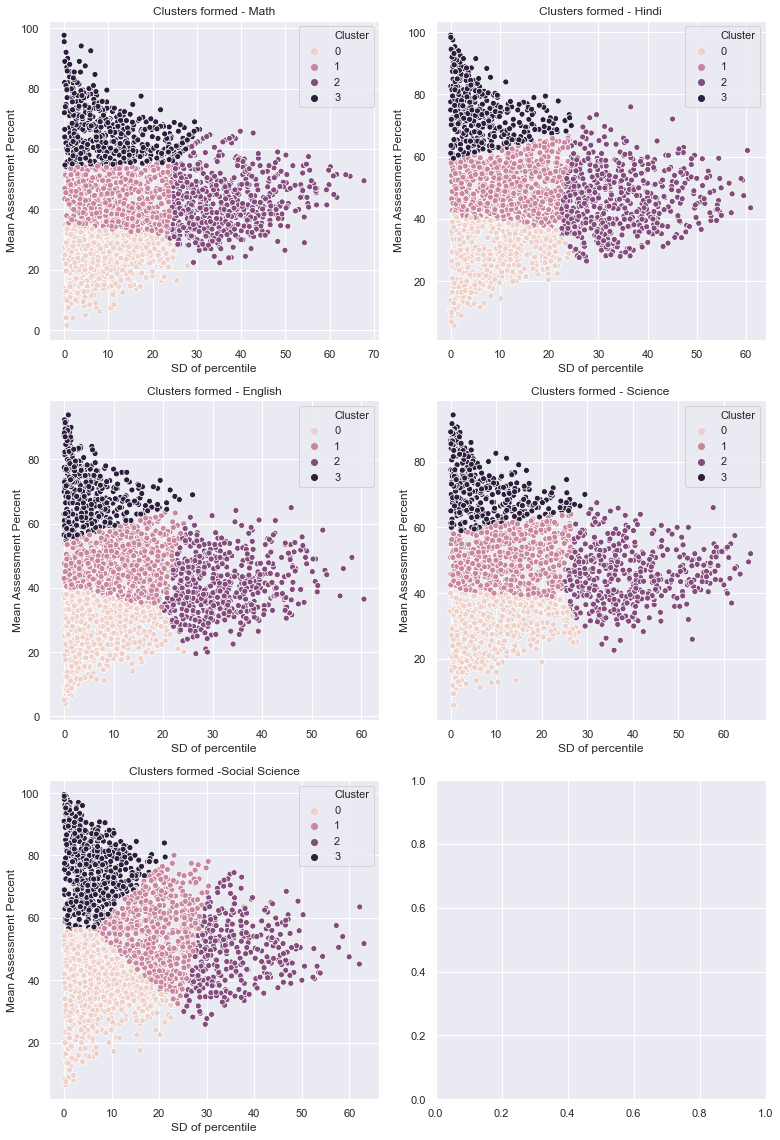

In [51]:
Math_clus_data =  clustering_subj(students_2exams_data_stud_subj_lvl,'Maths')
SSc_clus_data = clustering_subj(students_2exams_data_stud_subj_lvl,'Social Science')
Eng_clus_data = clustering_subj(students_2exams_data_stud_subj_lvl,'English')
Sc_clus_data = clustering_subj(students_2exams_data_stud_subj_lvl,'Science')
Hindi_clus_data = clustering_subj(students_2exams_data_stud_subj_lvl,'Hindi')

sns.set(rc={'figure.figsize':(11,16)})
fig, axs = plt.subplots(3,2)
sns.scatterplot( x='SD of percentile', y='Mean Assessment Percent', data=Math_clus_data, hue="Cluster",ax = axs[0][0]).set(title='Clusters formed '+ '- Math')

sns.scatterplot( x='SD of percentile', y='Mean Assessment Percent', data=SSc_clus_data, hue="Cluster",ax = axs[0][1]).set(title='Clusters formed '+ '- Hindi')

sns.scatterplot( x='SD of percentile', y='Mean Assessment Percent', data=Eng_clus_data, hue="Cluster",ax = axs[1][0]).set(title='Clusters formed '+ '- English')

sns.scatterplot( x='SD of percentile', y='Mean Assessment Percent', data=Sc_clus_data, hue="Cluster",ax = axs[1][1]).set(title='Clusters formed '+ '- Science')

sns.scatterplot( x='SD of percentile', y='Mean Assessment Percent', data=Hindi_clus_data, hue="Cluster",ax = axs[2][0]).set(title='Clusters formed '+ '-Social Science')

fig.tight_layout()
plt.show()

We see that 4 similar clusters are being formed across the subjects. The clustering process was modified to ensure that similar clusters are simlarly labelled across the subjects. 

For example,the bottom cluster is always labelled as 0 across the subjects 

##### Cluster Interpretation: 

###### Cluster 0 :   
This is the cluster with the lowest mean score and lowest standard-deviation of percentile (bottom left cluster)

These are the students who are consistenly doing poorly. 

These student must be the focus of the basic programs as they are consistently failing the assessments and are behind the rest of the class in understanding the outcomes. 

###### Cluster 1 :   
This is the cluster with the medium mean score and low standard-deviation of percentile (bottom left cluster)

These are the students who have an average score and haven't shown much variance in their scores. The lower half must be watched carefully so that they don't slip into the poorly perfroming cohort. 


###### Cluster 2 :   
This is the cluster with the medium mean score and high standard-deviation of percentile (bottom left cluster)

These are the students who have an average score but have at some point shown good performance. 
THese students have good potential and must be the focus of programs that look at improving the school  merit performance as they could be pushed more easily to get higher scores

###### Cluster 3 :   
This is the cluster with the high mean score and low standard-deviation of percentile (bottom left cluster)

These are the students who have consistenly shown good performance and are the least cause of worry

#### Looking at students belonging to clusters across subjects:

At a student level, I have summed up the clusters assigned to a student for each subject. 
For example, if a student belongs to cluster 0 in all the 5 subjects, his total cluster score will be 0 
If they belong to the top cluster (3) in all the 5 subjects, their cluster score will be 15

Plotting ahistogram of the same:

In [52]:
Hindi_clus_data = Hindi_clus_data.rename(columns = {"Cluster":"Hindi_cluster"})
SSc_clus_data = SSc_clus_data.rename(columns = {"Cluster":"Ssc_cluster"})
Eng_clus_data = Eng_clus_data.rename(columns = {"Cluster":"Eng_cluster"})
Sc_clus_data = Sc_clus_data.rename(columns = {"Cluster":"Sc_cluster"})
Math_clus_data = Math_clus_data.rename(columns = {"Cluster":"Math_cluster"})


In [53]:
all_subject_clusters =  Hindi_clus_data.merge(SSc_clus_data,on='student_id').merge(Eng_clus_data,on='student_id').merge(Sc_clus_data,on='student_id').merge(Math_clus_data,on='student_id')
all_subject_clusters_df =   all_subject_clusters[['student_id','Hindi_cluster','Ssc_cluster','Eng_cluster','Sc_cluster','Math_cluster']]
all_subject_clusters_df['sum_clusters'] = all_subject_clusters_df['Hindi_cluster'] + all_subject_clusters_df['Ssc_cluster'] + all_subject_clusters_df['Eng_cluster'] + all_subject_clusters_df['Sc_cluster'] + all_subject_clusters_df['Math_cluster'] 

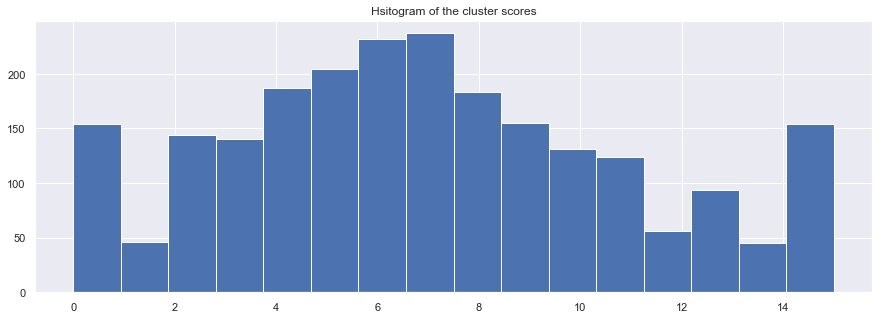

In [59]:
all_subject_clusters_df['sum_clusters'].hist(bins = 16)
plt.title('Hsitogram of the cluster scores')
plt.rcParams["figure.figsize"] = (15,5)
plt.show()

We see that is forms the usual normal curve except at the edges, the students who belong to cluster 0 in one subject tend to belong to  cluster 0 in all of them and those who belong to 3 in one, tend to belong to 3 in all of them

### Re-doing for Hamirpur:

In [69]:
sql_stmnt = '''
CREATE TEMP table test_view_submissions_data_Shimla AS
select distinct assessment_percent,
    assessment_grade,
    CASE WHEN assessment_percent in  (0,-1) THEN  assessment_grade
     WHEN assessment_percent is null THEN assessment_grade
     WHEN assessment_percent BETWEEN 80 AND 100 THEN  'A'
     WHEN assessment_percent BETWEEN 65 AND 80 THEN  'B'
     WHEN assessment_percent BETWEEN 50 AND 65 THEN  'C'
     WHEN assessment_percent BETWEEN 35 AND 50 THEN  'D'
     WHEN assessment_percent BETWEEN 0 AND 35 THEN 'E' 
    END AS assessment_grade_all,
    CASE WHEN (assessment_percent not in (0,-1) and assessment_percent is not NULL) THEN  assessment_percent
     WHEN assessment_grade = 'A' THEN 87.5
     WHEN assessment_grade = 'B' THEN 72
     WHEN assessment_grade = 'C' THEN 57
     WHEN assessment_grade = 'D' THEN 42
     WHEN assessment_grade = 'E' THEN 24
     WHEN assessment_grade = 'Z' THEN NULL
    END AS assessment_percent_all,

    base.grade_number as subm_grade_number,
    student.grade_number as stud_grade_number,
    --subject.grade_number as Subject_grade_number,
    --subject_id,
    subject.name as Subject_desc,
    assessment_id,
    student_id,
    student.section as section,
    category,
    is_cwsn,
    admission_number,
    previous_acad_year,
    grade_year_mapping,
    deadline.date as submission_date, 
    deadline.acad_year as submission_academic_year ,
    CASE WHEN  assessment_type."desc" IS NULL THEN assessment."type" ELSE assessment_type."desc" 
    END AS assessment_type ,
    location.district as district,
    location.block as block, 
    location.cluster as cluster
     from student_submission base
    left join student on base.student_id  = student.id
        left join school on student.school_id = school.id
        left join assessment on base.assessment_id =  assessment.id   
        left join assessment_type on  assessment.type_v2_id  = assessment_type.id
        left join deadline on assessment.deadline_id =  deadline.id
        left join subject on base.subject_id =  subject.id 
        left join location  on school.location_id = location.id
        where student.is_enabled = 't'
            and school.is_active =  't'
            and school.udise > 1111111111 
            and location.district = 'HAMIRPUR' '''

df = run_sql_code(sql_stmnt,conn)

In [72]:
sql_stmnt = '''
Select *,RANK() OVER(PARTITION BY assessment_id,Subject_desc,subm_grade_number 
        ORDER BY assessment_percent_all DESC) as grade_number,
        COUNT(*) OVER  (PARTITION BY  assessment_id,Subject_desc,subm_grade_number ) as frequency,

100-(RANK() OVER(PARTITION BY assessment_id,Subject_desc,subm_grade_number 
        ORDER BY assessment_percent_all DESC) *100.000) / 
        COUNT(*) OVER  (PARTITION BY  assessment_id,Subject_desc,subm_grade_number ) as percentile_Score_Stud, 
        CASE WHEN assessment_grade_all in ('E') THEN 1 ELSE 0 END AS pass_fail
        from (
select base.* from test_view_submissions_data_Shimla base 
inner join 
(select * from
(select student_id,assessment_id,Subject_desc,subm_grade_number, count(distinct assessment_percent_all) as count_assessment 
from test_view_submissions_data_Shimla
where assessment_percent_all IS NOT NULL
group by  student_id,assessment_id,Subject_desc,subm_grade_number ) a
where count_assessment = 1) a 
on base.student_id =  a.student_id
and base.assessment_id  =  a.assessment_id
and base.Subject_desc = a.Subject_desc
and base.subm_grade_number  = a.subm_grade_number) a
where assessment_percent_all is not null
             '''

df = run_sql_code(sql_stmnt,conn)

In [73]:
base_df = df
#base_df.to_csv('D:/Samagra/Samarth LR/Hamirpur_df.csv',index=False)
#base_df =  pd.read_csv('D:/Samagra/Samarth LR/Hamirpur_df.csv')

In [76]:
base_df_marks =  base_df.loc[~base_df['assessment_percent'].isin([-1.0,0]),:]
base_df_marks_9_10 =  base_df_marks.loc[base_df['subm_grade_number'].isin([9,10]),:]

base_df_grades =  base_df.loc[base_df['assessment_percent'].isin([-1.0,0]),:]
base_df_grades= base_df_grades.loc[base_df_grades['assessment_type'].isin(['FA1','FA2','SA1','SA2']),:]
base_df_grades['grade_assestype'] = base_df_grades['subm_grade_number'].astype('str') + base_df_grades['assessment_type']
base_df_marks_9_10['grade_assestype'] = base_df_marks_9_10['subm_grade_number'].astype('str') + base_df_marks_9_10['assessment_type']

years_students = base_df_marks_9_10.groupby(['student_id']).agg({'subm_grade_number':'nunique', 'grade_assestype':'nunique'}).reset_index()
#years_students.groupby(['subm_grade_number','grade_assestype']).agg({'student_id':'nunique'}).reset_index()
students_2exams_students =  years_students.loc[years_students['grade_assestype']==2,'student_id']
students_2exams_data = base_df_marks_9_10.loc[ base_df_marks_9_10['student_id'].isin(students_2exams_students.values),:]

students_2exams_data1 = students_2exams_data.loc[students_2exams_data['frequency'] > 20,:]

In [89]:
students_2exams_data1['percentile_score_stud'] = students_2exams_data1['percentile_score_stud'].astype('float')
students_2exams_data_stud_subj_lvl = students_2exams_data1.groupby(['student_id','subject_desc']).agg({'assessment_percent_all':'mean','percentile_score_stud':'std'}).reset_index()
students_2exams_data_stud_subj_lvl = students_2exams_data_stud_subj_lvl.loc[~students_2exams_data_stud_subj_lvl['percentile_score_stud'].isnull(),:]

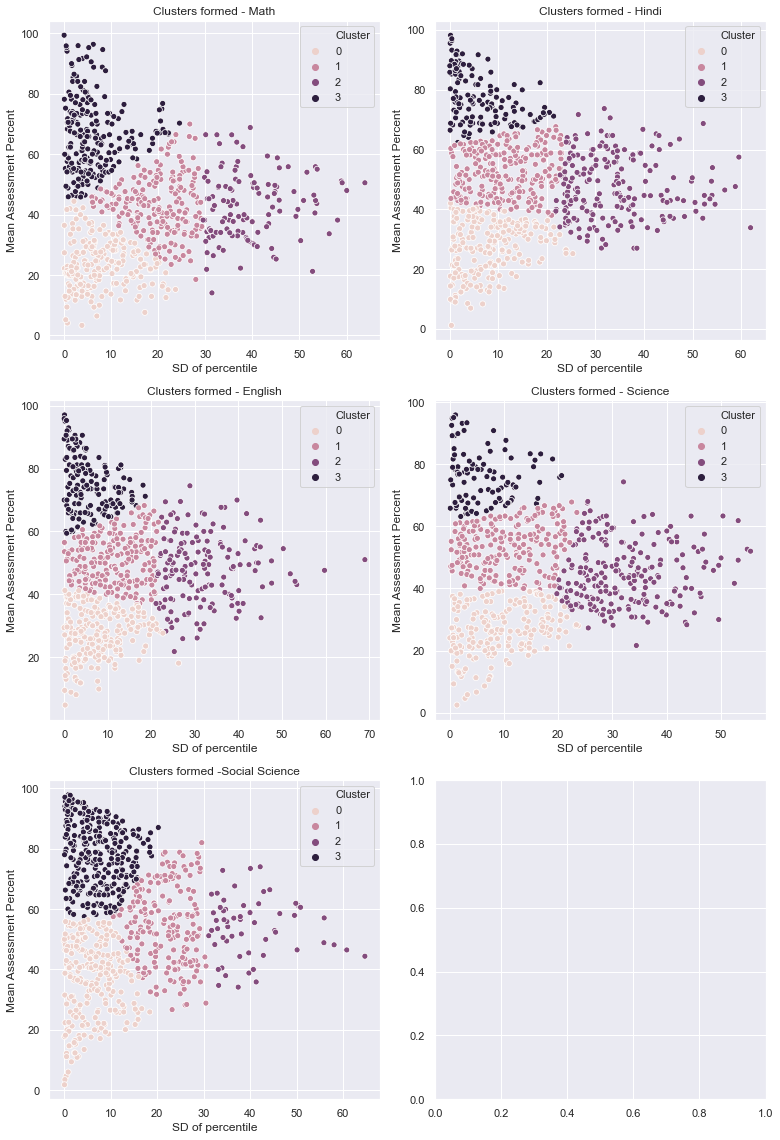

In [90]:
Math_clus_data =  clustering_subj(students_2exams_data_stud_subj_lvl,'Maths')
SSc_clus_data = clustering_subj(students_2exams_data_stud_subj_lvl,'Social Science')
Eng_clus_data = clustering_subj(students_2exams_data_stud_subj_lvl,'English')
Sc_clus_data = clustering_subj(students_2exams_data_stud_subj_lvl,'Science')
Hindi_clus_data = clustering_subj(students_2exams_data_stud_subj_lvl,'Hindi')

sns.set(rc={'figure.figsize':(11,16)})
fig, axs = plt.subplots(3,2)
sns.scatterplot( x='SD of percentile', y='Mean Assessment Percent', data=Math_clus_data, hue="Cluster",ax = axs[0][0]).set(title='Clusters formed '+ '- Math')

sns.scatterplot( x='SD of percentile', y='Mean Assessment Percent', data=SSc_clus_data, hue="Cluster",ax = axs[0][1]).set(title='Clusters formed '+ '- Hindi')

sns.scatterplot( x='SD of percentile', y='Mean Assessment Percent', data=Eng_clus_data, hue="Cluster",ax = axs[1][0]).set(title='Clusters formed '+ '- English')

sns.scatterplot( x='SD of percentile', y='Mean Assessment Percent', data=Sc_clus_data, hue="Cluster",ax = axs[1][1]).set(title='Clusters formed '+ '- Science')

sns.scatterplot( x='SD of percentile', y='Mean Assessment Percent', data=Hindi_clus_data, hue="Cluster",ax = axs[2][0]).set(title='Clusters formed '+ '-Social Science')

fig.tight_layout()
plt.show()

We can see similar clusters being formed with less data points for a more backward district

Potential pain point on expanding:  The cluster shape may vary a bit on adding more assessments. 
It is likely that the average variance will decrease on adding more tests. However we still expect 4 clusters to be formed and th logic to hold, the difference is that the differences in variance between the clusters will be lower 